In [1]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(46)
torch.set_default_device(device)

device

'cuda'

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    download=True,
)
test_data = datasets.MNIST(root="data", train=False, transform=ToTensor())
X_train_not_normalized = train_data.data.float().to(device=device)
y_train = train_data.targets.to(device=device)
X_test_not_normalized = test_data.data.float().to(device=device)
y_test = test_data.targets.to(device=device)

X_train = (X_train_not_normalized - X_train_not_normalized.min()) / (
    X_train_not_normalized.max() - X_train_not_normalized.min()
)
X_test = (X_test_not_normalized - X_test_not_normalized.min()) / (
    X_test_not_normalized.max() - X_test_not_normalized.min()
)

In [3]:
class Teacher(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.activation_function = nn.ReLU()

        self.flatten = nn.Flatten()

        self.layer_one = nn.Linear(
            in_features=784, out_features=1024, dtype=torch.float
        )
        self.layer_two = nn.Linear(
            in_features=1024, out_features=512, dtype=torch.float
        )
        self.layer_three = nn.Linear(
            in_features=512, out_features=10, dtype=torch.float
        )

    def forward(self, x: torch.Tensor):
        out = self.flatten(x)
        out = self.activation_function(self.layer_one(out))
        out = self.activation_function(self.layer_two(out))
        out = self.layer_three(out)
        return out


class Student(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.activation_function = nn.ReLU()

        self.flatten = nn.Flatten()

        self.layer_one = nn.Linear(in_features=784, out_features=128, dtype=torch.float)
        self.layer_two = nn.Linear(in_features=128, out_features=64, dtype=torch.float)
        self.layer_three = nn.Linear(in_features=64, out_features=10, dtype=torch.float)

    def forward(self, x: torch.Tensor):
        out = self.flatten(x)
        out = self.activation_function(self.layer_one(out))
        out = self.activation_function(self.layer_two(out))
        out = self.layer_three(out)
        return out


teacher_model = Teacher()
student_model = Student()

teacher_model.load_state_dict(torch.load("./TeacherModel.pth"))

teacher_y_train_logits = teacher_model(X_train)
teacher_y_train_logits_softmaxed = torch.softmax(teacher_y_train_logits, dim=1)

_, teacher_y_train = teacher_y_train_logits.max(dim=1)
teacher_y_test_logits = teacher_model(X_test)
teacher_y_test_logits_softmaxed = torch.softmax(teacher_y_test_logits, dim=1)
_, teacher_y_test = teacher_y_test_logits_softmaxed.max(dim=1)
teacher_y_train = teacher_y_train.to(dtype=torch.float)
teacher_y_test = teacher_y_test.to(dtype=torch.float)
teacher_model(X_test)

tensor([[-0.7806, -1.2134, -0.9218,  ...,  2.6811, -0.0129,  1.6270],
        [ 0.3770,  0.1848,  1.6529,  ..., -2.3801,  0.7674, -2.2873],
        [-1.4866,  2.3106,  0.3854,  ..., -0.5120,  0.4096, -0.5343],
        ...,
        [-2.4371, -0.9960, -0.8187,  ...,  1.6459,  0.5324,  2.0795],
        [-0.3726,  0.1539, -0.0482,  ..., -0.3100,  0.6986, -0.3425],
        [ 1.5989, -2.3355,  1.6082,  ..., -2.1871, -0.3209, -1.1665]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [4]:
import math
import matplotlib.pyplot as plt
import time

EPOCHS = 10
ALPHA = 0.01
BATCH_SIZE = 32
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(student_model.parameters(), lr=ALPHA)


def printLogs(epoch, epochs, loss, accuracy, test_accuracy, test_loss):
    print(
        f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%  | Test loss: {test_loss:.5f}"
    )


general_loss = []  # to be shown after epochs
general_test_loss = []  # to be shown after epochs
general_accuracy = []  # to be shown after epochs
general_test_accuracy = []  # to be shown after epochs
for epoch in range(EPOCHS):
    accuracies = []
    test_accuracies = []
    test_losses = []
    losses = []
    for batch_index in range(math.ceil(X_train.shape[0] / BATCH_SIZE)):
        student_model.train()
        # start_time = time.time()

        X_train_batch = X_train[
            batch_index * BATCH_SIZE : batch_index * BATCH_SIZE + BATCH_SIZE
        ]
        teacher_y_train_batch = teacher_y_train[
            batch_index * BATCH_SIZE : batch_index * BATCH_SIZE + BATCH_SIZE
        ]

        student_y_logits = student_model(X_train_batch)
        student_y_logits_softmaxed = torch.softmax(student_y_logits, dim=1)
        _, max_indices = student_y_logits_softmaxed.max(dim=1)

        accuracy = (
            torch.eq(teacher_y_train_batch, max_indices).count_nonzero()
            / teacher_y_train_batch.__len__()
            * 100
        )

        accuracies.append(accuracy)

        loss = loss_function(
            student_y_logits,
            teacher_y_train_logits[
                batch_index * BATCH_SIZE : batch_index * BATCH_SIZE + BATCH_SIZE
            ],
        )

        losses.append(loss.cpu())

        optimizer.zero_grad()

        loss.backward(retain_graph=True)

        optimizer.step()
        # end_time = time.time()
        # print(f"Train duration :{end_time-start_time}")

        student_model.eval()

        with torch.inference_mode():
            # start_time = time.time()
            student_y_test_logits = student_model(X_test)
            student_test_logits_softmaxed = torch.softmax(student_model(X_test), dim=1)
            _, max_indices = student_test_logits_softmaxed.max(dim=1)

            test_loss = loss_function(
                student_y_test_logits,
                teacher_y_test_logits,
            )
            test_accuracy = (
                torch.eq(teacher_y_test, max_indices).count_nonzero()
                / teacher_y_test.__len__()
                * 100
            )

            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss.cpu())
            # end_time = time.time()
            # print(f"Test duration :{end_time-start_time}")

    average_test_loss = torch.tensor(test_losses).mean()
    average_loss = torch.tensor(losses).mean()
    average_test_accuracy = torch.tensor(test_accuracies).mean()
    average_accuracy = torch.tensor(accuracies).mean()

    test_losses = []  # reset for the next epoch
    losses = []
    test_accuracies = []
    accuracies = []

    general_loss.append(average_loss.item())
    general_test_loss.append(average_test_loss.item())
    general_test_accuracy.append(average_test_accuracy.item())
    general_accuracy.append(average_accuracy.item())
    printLogs(
        epoch,
        EPOCHS,
        average_loss,
        average_accuracy,
        average_test_accuracy,
        average_test_loss,
    )

Epoch: 0 | Loss: 0.23613, Accuracy: 67.99%, Test Accuracy: 68.50%  | Test loss: 0.24086
Epoch: 1 | Loss: 0.00986, Accuracy: 91.75%, Test Accuracy: 92.20%  | Test loss: 0.01001
Epoch: 2 | Loss: 0.00467, Accuracy: 94.35%, Test Accuracy: 94.83%  | Test loss: 0.00475
Epoch: 3 | Loss: 0.00347, Accuracy: 95.24%, Test Accuracy: 95.59%  | Test loss: 0.00354
Epoch: 4 | Loss: 0.00290, Accuracy: 95.83%, Test Accuracy: 96.10%  | Test loss: 0.00297
Epoch: 5 | Loss: 0.00254, Accuracy: 96.26%, Test Accuracy: 96.52%  | Test loss: 0.00261
Epoch: 6 | Loss: 0.00229, Accuracy: 96.60%, Test Accuracy: 96.80%  | Test loss: 0.00235
Epoch: 7 | Loss: 0.00211, Accuracy: 96.84%, Test Accuracy: 97.00%  | Test loss: 0.00217
Epoch: 8 | Loss: 0.00196, Accuracy: 97.01%, Test Accuracy: 97.20%  | Test loss: 0.00202
Epoch: 9 | Loss: 0.00185, Accuracy: 97.17%, Test Accuracy: 97.35%  | Test loss: 0.00190



Misclassification in 10000 pictures: 7835


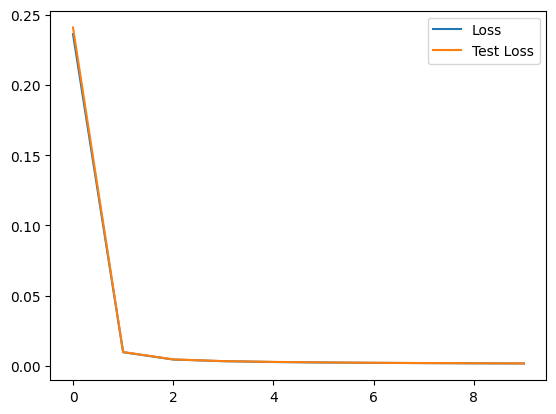

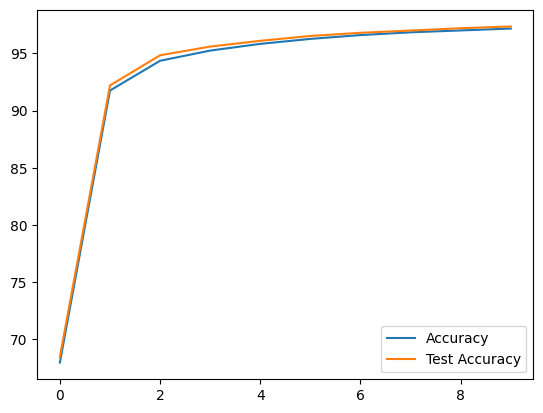

In [5]:
print()
student_model(X_test)
_, max_indices = torch.softmax(student_model(X_test), dim=1).max(dim=1)
print(
    f"Misclassification in {y_test.__len__()} pictures: {(max_indices==y_test).count_nonzero()}"
)

plt.plot(general_loss, label="Loss")
plt.plot(general_test_loss, label="Test Loss")
plt.legend()
plt.show()
plt.plot(general_accuracy, label="Accuracy")
plt.plot(general_test_accuracy, label="Test Accuracy")
plt.legend()
plt.show()